In [24]:
import sys
import astrometry
import numpy as np
import timeit
import time
import seaborn as sns
from astropy.stats import sigma_clipped_stats
from astropy import wcs
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pickle
import math
import pdb
import random
import warnings
import pandas as pd
import os
import matplotlib.pyplot as plt
import importlib
import copy
from astropy.nddata import Cutout2D
import scipy.optimize as opt

import matplotlib as mpl
%matplotlib inline
from scipy.stats import binned_statistic
import scipy.optimize as opt
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = (6,4)

pi = math.pi

#Importing Simulator 
#import SPHEREx_SkySimulator as SPsky
import SPHEREx_ObsSimulator as SPobs
import SPHEREx_InstrumentSimulator as SPinst
from SPHEREx_Simulator_Tools import SPHEREx_Logger
from pkg_resources import resource_filename
from astropy.io import fits
import pandas as pd
from scipy.signal import convolve2d
from skimage.transform import downscale_local_mean
from astropy.stats import sigma_clipped_stats
from SPHEREx_Simulator_Tools import data_filename
 
from tractor_utils import *

import astropy.units as u

Logger = SPHEREx_Logger()

In [25]:
instrument = SPinst.Instrument(psf=data_filename('psf/simulated_PSF_database.fits'),
                               psf_downsample_by_array = {1:4, 2:4, 3:4, 4:2, 5:2, 6:2},
                               psf_trim_by_array = {1:32, 2:32, 3:32, 4:32, 5:32, 6:32},
                               noise_model = SPinst.white_noise,
                               dark_current_model = SPinst.poisson_dark_current,
                               lvf_model = SPinst.smile_lvf,
                               Logger=Logger)

Rank 0000 06-27-24 11:45:58 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits


In [15]:

# given umodel (suppose an D*N*N matrix where each image is of the size N*N and there are D of them 
# (D number of sources))

def Covariance_calc(umodels, sigma):
    """
    umodels = tractor output unit flux models
    sigma = sky std
    -----
    returns the fisher matrix, covariance matrix, and flux error
    """
    
    D = len(umodels[0]) # number of sources
    models_cov = np.zeros(shape=(D, 20, 20)) # this will go into Covariance_calc
    for i, umods in enumerate(umodels):
        for ui, um in enumerate(umods):
            x0, y0 = um.x0, um.y0
            uh, uw = um.shape
            slc = slice(y0, y0 + uh), slice(x0, x0 + uw)
            models_cov[ui][slc] += um.getImage() # only PSF

    F = np.zeros(shape=(D,D)) # initialize fisher information matrix
    for i in range(D):
        for j in range(D):
            # i,j th entry of the fisher matrix
            F[i,j] = - np.sum(models_cov[i]*models_cov[j]) / sigma**2        
    
    # check if F is invertible or not
    if np.linalg.det(F)==0.:
        #print('F not invertible!')
        C = np.inf + np.zeros_like(F)
        error = -np.diag(C)
    else:
        C = np.linalg.inv(F)
        error = np.sqrt(-np.diag(C))
        
    ### calculate F1, F2, F2/F1
    F1 = error / sigma**2
    F2 = - 1/(np.diag(F) * sigma**2)
        
    # print('Covariance matrix = ', C)
    return(F, C, error, F1, F2)

### tractor fit

def Sources_gen_multiple(N_sources, Coord, subpixel, fluxes, array_number, N_image):
    """
    N_sources = number of sources to generate
    Coord = coordinates of these sources (we place the first primary source at the center)
    fluxes = flux of the sources 
    array_number = SPHEREx array number
    N_image = size of the image containing these sources
    -----
    Returns: 1. a 3D array of size N_sources * (N_image/5) * (N_image/5) containing only psf of each source. This will be used in the covariance calculation.
             2. a 2D image of size (N_image/5) * (N_image/5) plotting all sources (psfs+fluxes). This will be fed into tractor 
    
    """
    (x0, y0) = Coord[0] # the first psf coord
    (sub_x, sub_y) = subpixel
    downscale = 5
    PSF_ds = np.zeros(shape=(N_sources, int(N_image/downscale), int(N_image/downscale)))
    #for rendering
    Sources = np.zeros(shape=(int(N_image/downscale), int(N_image/downscale)))
    PSFs = np.zeros(shape=(int(N_image/downscale), int(N_image/downscale)))
#     test_psf = np.zeros(shape=(N_image, N_image)) # for plotting purpose
    
    for i in range(N_sources):
        (x_i, y_i) = Coord[i]
        xoff = x_i - x0
        yoff = y_i - y0
        psf_i = instrument.PSF.psf(x_i, y_i, array=array_number)
        PSF_i = np.zeros((N_image, N_image))
        s = int(psf_i.shape[0]/2.)
        
        if i==0: # add subpixel shift to the primary source
            PSF_i[(int(N_image/2)+1+sub_y+yoff-s):(int(N_image/2)+1+sub_y+yoff+s),
                (int(N_image/2)+sub_x+xoff-s):(int(N_image/2)+sub_x+xoff+s)] += psf_i.T
        else:
            PSF_i[(int(N_image/2)+1+yoff-s):(int(N_image/2)+1+yoff+s),
                (int(N_image/2)+xoff-s):(int(N_image/2)+xoff+s)] += psf_i.T
        PSF_i_ds = (downscale_local_mean(PSF_i,
                                         (downscale, downscale))
                    * downscale**2)
        PSF_ds[i] = PSF_i_ds
        
        
        # including sources
        source_i = np.zeros((N_image, N_image))
        if i==0:
            source_i[(int(N_image/2)+1+sub_y+yoff-s):(int(N_image/2)+1+sub_y+yoff+s),
                 (int(N_image/2)+sub_x+xoff-s):(int(N_image/2)+sub_x+xoff+s)] += fluxes[i] * psf_i.T
        else:
            source_i[(int(N_image/2)+1+yoff-s):(int(N_image/2)+1+yoff+s),
                 (int(N_image/2)+xoff-s):(int(N_image/2)+xoff+s)] += fluxes[i] * psf_i.T
        
        source_i_ds = (downscale_local_mean(source_i,
                                         (downscale, downscale))
                    * downscale**2)
        
        
        # generating a single sky image for all sources
        Sources += source_i_ds 
        PSFs += PSF_i_ds
        
#         test_psf += PSF_i
    
#     plt.imshow(test_psf)
        
    return(PSF_ds, Sources) # umodels, source_pixels_sky

### multiple sources tractor fit
def Tractor_blended(N_sources, Coord, fluxes, size, subpixel=(0,0), array_number=3, sigma=0.4):
    """
    N_sources = number of sources in the cutout
    Coord = 2D tuple including coordinates of the two sources 
    fluxes = 2D tuple including flux of the two sources
    size = size of the oversampled image
    subpixel = subpixel shift of the primary source
    """
    (xa, ya) = Coord[0]
    (xb, yb) = Coord[1]
    (sub_x, sub_y) = subpixel
    (PSF_weightings, source_pixels_sky) = Sources_gen_multiple(N_sources, Coord, subpixel, fluxes, array_number, N_image=size)
#     plt.imshow(source_pixels_sky)
#     plt.plot(Coord[0][0]/5-10, Coord[0][1]/5-10, 'o', color='red', ms=7)
#     plt.plot(Coord[1][0]/5-10, Coord[1][1]/5-10, 'o', color='red', ms=7)
#     plt.plot(Coord[2][0]/5-10, Coord[2][1]/5-10, 'o', color='red', ms=7)
#     plt.colorbar()
#     plt.xlim(7,13)
#     plt.ylim(13,7)
    #plt.imshow(umodels[1],alpha=0.5)

    #Add some random noise
    noise = np.random.randn(int(size/5),int(size/5))*sigma
    
    tractor_source_list = []
    for i in range(N_sources):
        xoff = Coord[i][0] - xa
        yoff = Coord[i][1] - ya
        if i==0: # the primary source
            xpos=(int(size/2)+sub_x-1)/5.-0.4
            ypos=(int(size/2)+sub_y)/5.-0.4
        else: 
            xpos = (int(size/2)-1+xoff)/5.-0.4
            ypos = (int(size/2)+yoff)/5.-0.4
            
        tractor_source_list.append(PointSource(PixPos(xpos,ypos),Flux(np.random.uniform(high=5000))))

    spherex_psf = SPHERExTractorPSF(instrument.PSF, array_number, xshift=xa, yshift=ya)
    
    inverse_variance = np.zeros_like(source_pixels_sky)+1/sigma**2
    tim = tractor.Image(data=source_pixels_sky+noise, invvar=inverse_variance,
                psf=spherex_psf, wcs=NullWCS(pixscale=6.2), photocal=LinearPhotoCal(1.),
                sky=ConstantSky(0.))
    
    for ii in range(len(tractor_source_list)):
        tractor_source_list[ii].freezeAllRecursive()
        tractor_source_list[ii].thawParam('brightness')
    
    tim.freezeAllRecursive() #Image parameters fixed

    trac_spherex = tractor.Tractor([tim], tractor_source_list)

    (optres) = trac_spherex.optimize_forced_photometry(variance=True) ## engine.py --> call optimize.py optimizer.optimize

    model=trac_spherex.getModelImage(0)
    
    out = []
    for ii in range(len(tractor_source_list)):
        out.append([ii+1,tractor_source_list[ii].getParams()[0],\
                    1/np.sqrt(optres.IV[ii])])
    fluxres = Table(rows=out,
            names=('ID', 'Flux', 'Fluxerr'),
            meta={'name': 'tractor_result'})
    # return(fluxres, PSF_weightings) 
    return(fluxres) # umods from tractor fit. This goes directly into Covariance_calc




In [19]:
### the first scenario 
Coord = ((100, 100), (102, 100), (100, 102))
Fluxes = (150, 200, 300)
subpixel = (0,0)
sigma = 0.4
N_sources = 3
(fluxres) = Tractor_blended(N_sources, Coord, Fluxes, 100, subpixel=subpixel, sigma=sigma)
fluxres

Rank 0000 06-27-24 11:38:47 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:38:47 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:38:47 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:38:47 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:38:47 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:38:47 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

ID,Flux,Fluxerr
int64,float64,float64
1,149.92404696514404,0.792364971262563
2,200.65058191460048,0.5848947514811479
3,298.7544043457956,0.6191505788549049


# With PSF, test the performance

In [20]:
def Covariance_calc(umod, sigma):
    """
    umodels = 3D array containing pixel weightings of each source
    sigma = sky std
    -----
    returns the fisher matrix, covariance matrix, and flux error
    """
    D = umod.shape[0] # number of sources
    F = np.zeros(shape=(D,D)) # initialize fisher information matrix
    for i in range(D):
        for j in range(D):
            # i,j th entry of the fisher matrix
            F[i,j] = - np.sum(umod[i]*umod[j]) / sigma**2        
    # print('F = ', F)
    
    # check if F is invertible or not
    if np.linalg.det(F)==0.:
        print('F not invertible!')
        C = np.inf + np.zeros_like(F)
        var = -np.diag(C)
    else:
        C = np.linalg.inv(F)
        var = -np.diag(C) #variance
        
    ### calculate F1, F2, F2/F1
    
        
    # print('Covariance matrix = ', C)
    return(F, C, var)

### generate multiple psf's

def PSF_gen_multiple(N_psf, Coord, array_number, N_image, plot=False):
    """
    N_psf = number of psf's to generate
    Coord = an N_psf dimentional tuple - coordinates of these psf's (we place the first psf at the center)
    array_number = SPHEREx array number
    N_image = size of the image containing these sources
    -----
    returns N_psf * N_image * N_image array containing psf's;
    plots the oversampled and downscaled psf's in the same image
    """
    (x0, y0) = Coord[0] # the first psf coord
    downscale = 5
    psf_ds = np.zeros(shape=(N_psf, int(N_image/downscale), int(N_image/downscale)))
    #for rendering
    psf_im_plt = np.zeros(shape=(int(N_image), int(N_image)))
    psf_ds_plt = np.zeros(shape=(int(N_image/downscale), int(N_image/downscale)))
    
    for i in range(N_psf):
        (x_i, y_i) = Coord[i]
        xoff = x_i - x0
        yoff = y_i - y0
        psf_i = instrument.PSF.psf(x_i, y_i, array=array_number)
        im_i = np.zeros((N_image, N_image))
        s = int(psf_i.shape[0]/2.)
        im_i[(int(N_image/2)+1+yoff-s):(int(N_image/2)+1+yoff+s),
            (int(N_image/2)+xoff-s):(int(N_image/2)+xoff+s)] += psf_i.T
        psf_i_ds = (downscale_local_mean(im_i,
                                         (downscale, downscale))
                    * downscale**2)
        psf_ds[i] = psf_i_ds
        
        # for rendering
        psf_im_plt += im_i
        psf_ds_plt += psf_i_ds

    
    if plot is not False:
        plt.figure(figsize=(10,3.5))
        plt.subplot(1,2,1)
        plt.imshow(psf_im_plt)
#         plt.plot(50,50, '*', color='white')
#         plt.xlim(40,60)
#         plt.ylim(40,60)
        plt.colorbar()
        plt.title('Oversampled PSF')
        plt.subplot(1,2,2)
        plt.imshow(psf_ds_plt)
        plt.colorbar()
        plt.title('Downsampled PSF')
        plt.show()
        
    return(psf_ds)



Rank 0000 06-27-24 11:49:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:49:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:49:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 11:49:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits


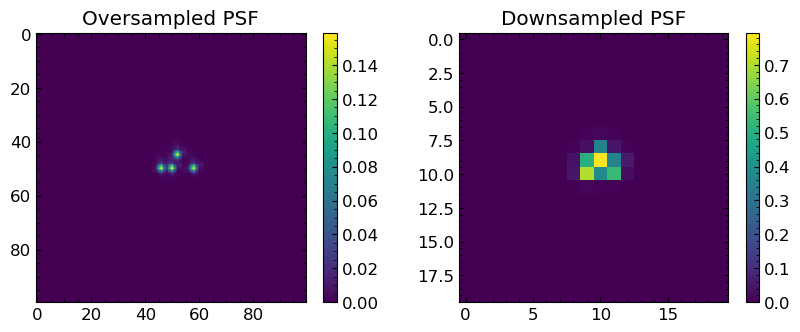

Time = 0.23508071899414062 ms


In [34]:
### fix the first three sources 
im_sigma = 1.0
coord = [(100,100), (96,100), (108, 100), (102, 95)]
umod = PSF_gen_multiple(4, coord, 4, 100, plot=True)

time_start = time.time()
Covariance_calc(umod, im_sigma)
time_end = time.time()
time_elapsed = time_end - time_start
print("Time = {} ms".format(time_elapsed*1e3))


Rank 0000 06-27-24 12:09:17 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits


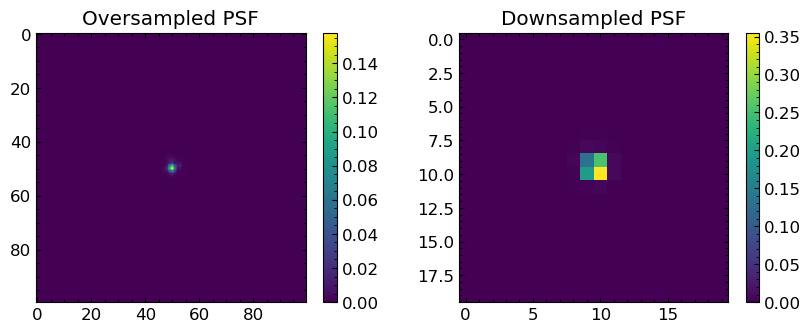

Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits


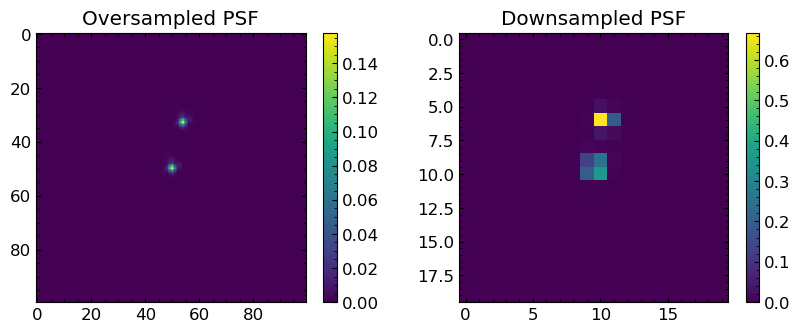

Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits


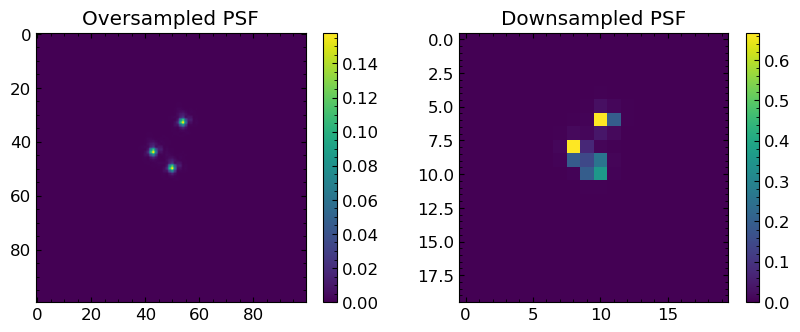

Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:18 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits


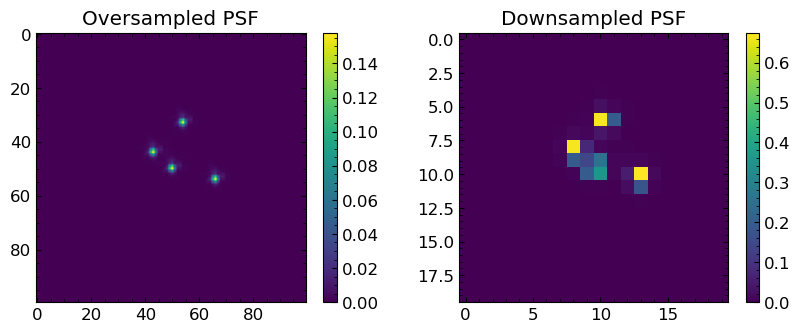

Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits


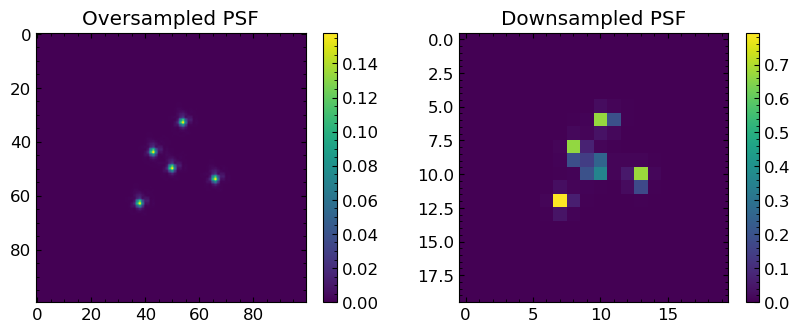

Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

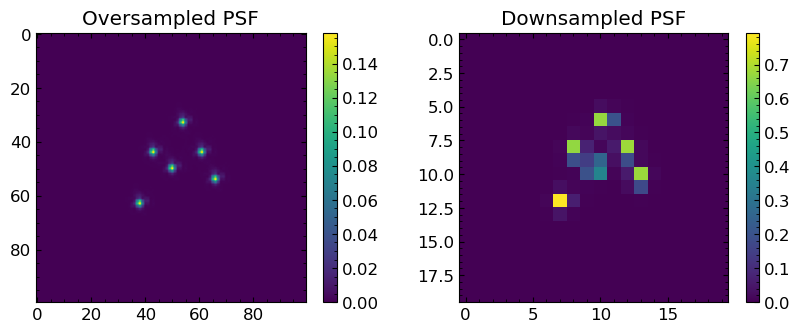

Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:19 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

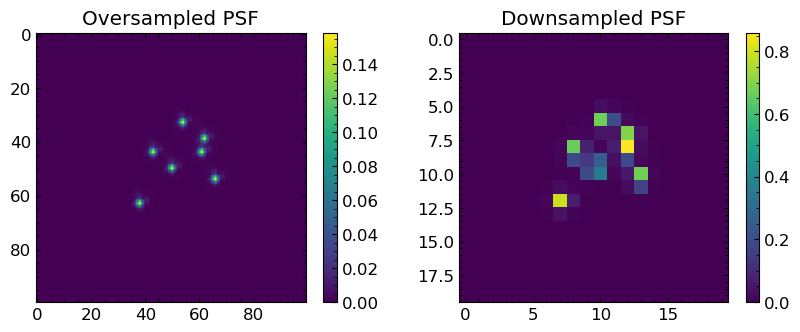

Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:20 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

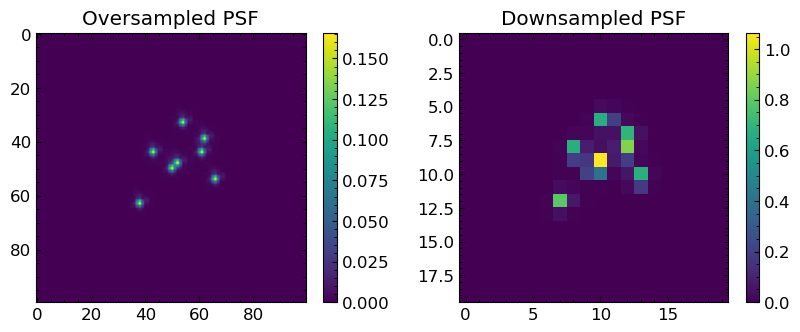

Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

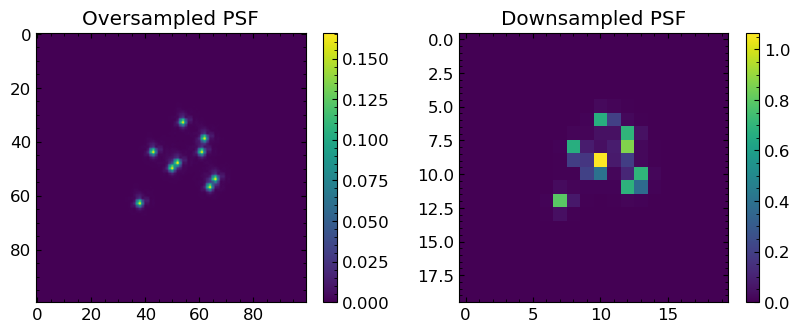

Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:21 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

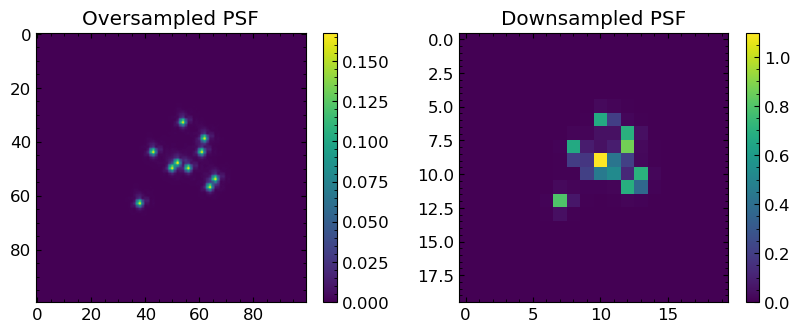

Rank 0000 06-27-24 12:09:22 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:22 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:22 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:22 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:22 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:22 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

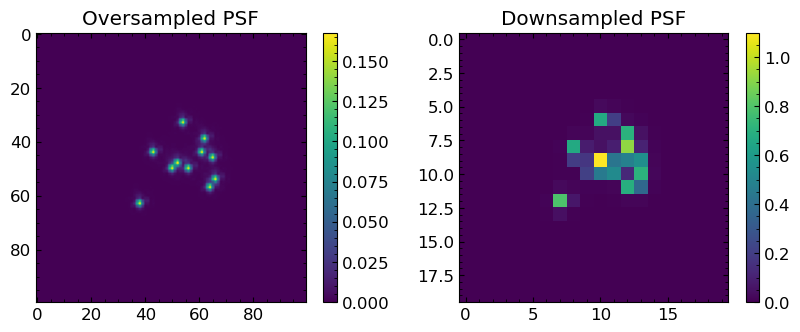

Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

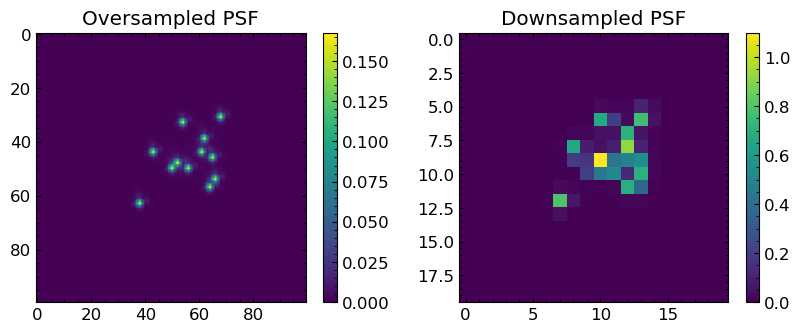

Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:23 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

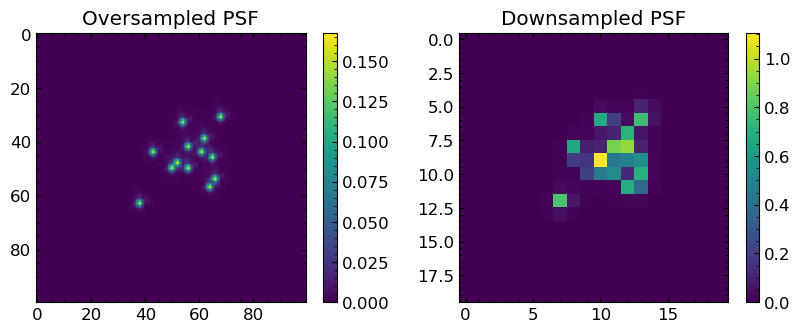

Rank 0000 06-27-24 12:09:24 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:24 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:24 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:24 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:24 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:24 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

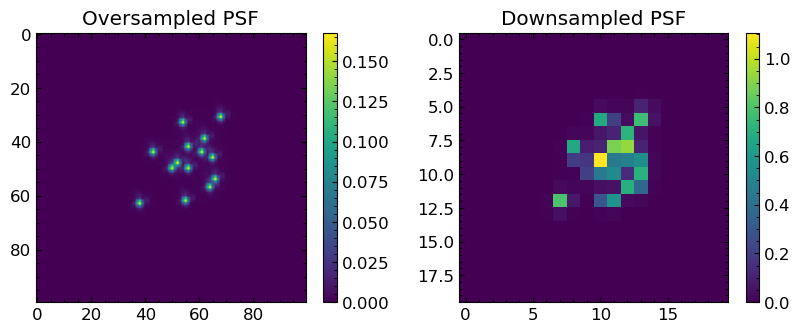

Rank 0000 06-27-24 12:09:25 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:25 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:25 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:25 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:25 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:25 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

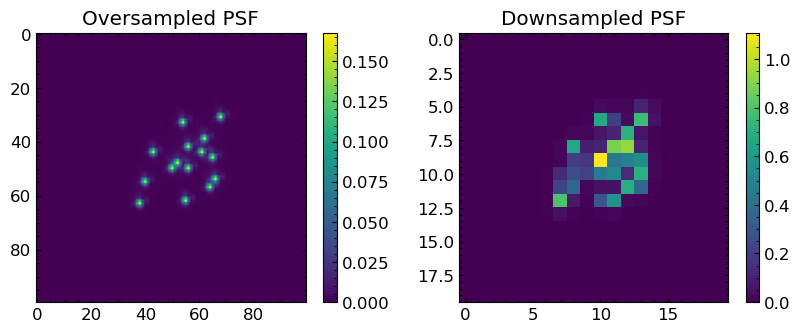

Rank 0000 06-27-24 12:09:26 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:26 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:26 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:26 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:26 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:26 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

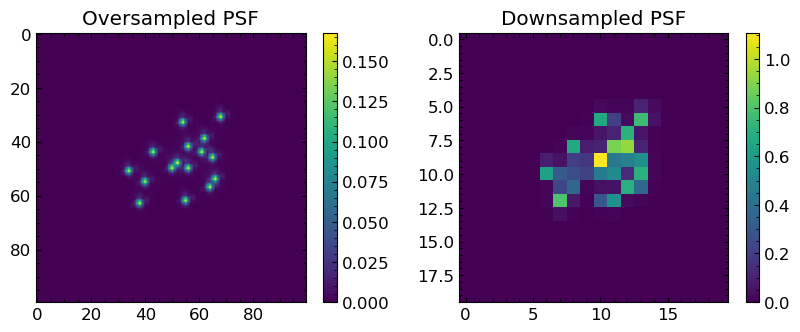

Rank 0000 06-27-24 12:09:27 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:27 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:27 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:27 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:27 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:27 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

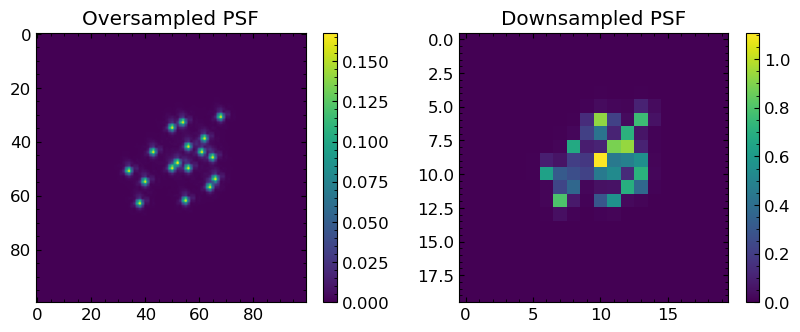

Rank 0000 06-27-24 12:09:28 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:28 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:28 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:28 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:28 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:28 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

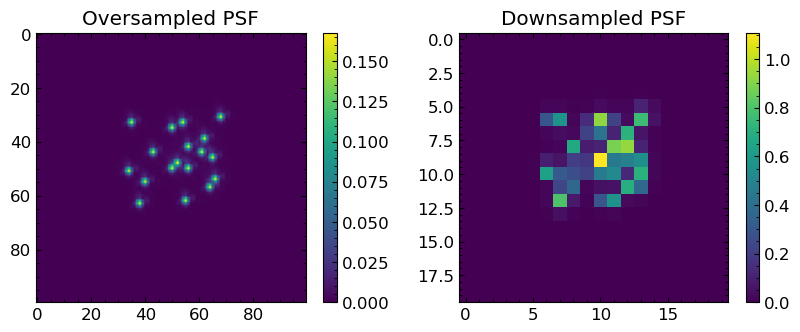

Rank 0000 06-27-24 12:09:29 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:29 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:29 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:29 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:29 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:29 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

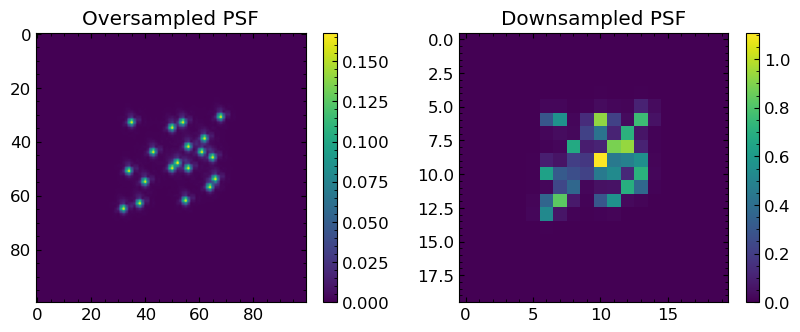

Rank 0000 06-27-24 12:09:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/python3.11/site-packages/SPHEREx_Simulator_Data/psf/simulated_PSF_database.fits
Rank 0000 06-27-24 12:09:31 INFO     Opening /Users/gemmahuai/anaconda3/envs/spherexsim_tractor/lib/

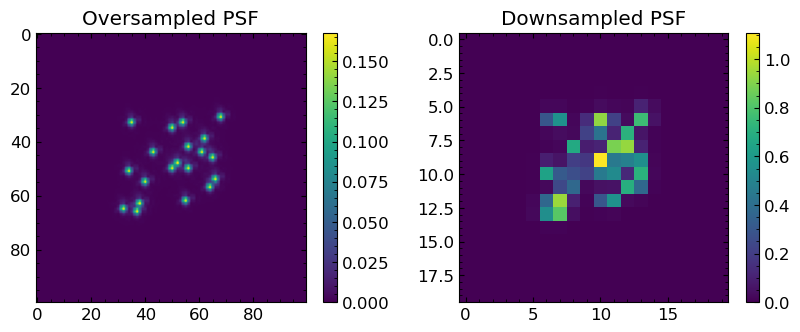

In [60]:
### how the performace scales with the number of nearby sources
N_sources = 20
N_timeavg = 1000
im_sigma = 1.
# put the main source at the center
coord = [(100,100)]
runtime = []

for i in range(N_sources):

    umod = PSF_gen_multiple(N_psf=i+1, 
                            Coord=coord, 
                            array_number=4,
                            N_image=100, 
                            plot=True)
    time_elapsed = []
    
    for j in range(N_timeavg):
        # average the runtime over multiple calculations
        time_start = time.time()
        
        Covariance_calc(umod, im_sigma)
        
        time_end = time.time()
        time_elapsed.append(time_end - time_start)
        # print("Time = {} ms".format(time_elapsed*1e3))

    runtime.append(np.mean(time_elapsed))
    
    # add one more source into the catalog
    coord_x, coord_y = np.random.randint(80, 120, size=2)
    coord.append((coord_x, coord_y))
    


Text(0, 0.5, 'Performance (ms)')

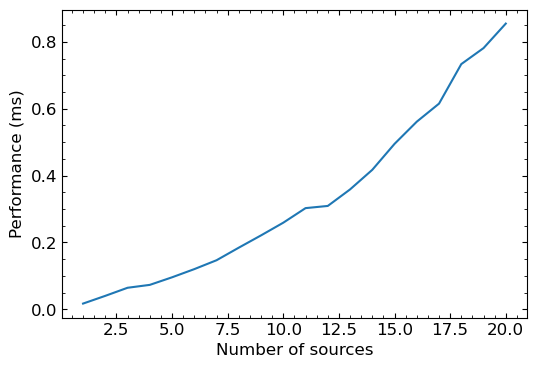

In [61]:
N_sources_array = np.arange(N_sources) + 1
plt.plot(N_sources_array, np.array(runtime) * 1e3)
plt.xlabel("Number of sources")
plt.ylabel("Performance (ms)")

In [62]:
np.linalg.det?

In [63]:
np.linalg.cholesky?